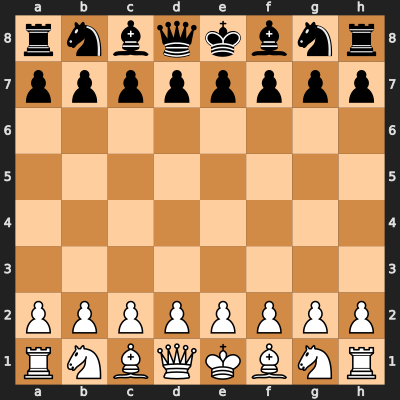

In [1]:
import chess
import chess.svg
from IPython.display import display, SVG

device = 'cuda:0'

# Create a chessboard
board = chess.Board()

# Display the chessboard
display(SVG(chess.svg.board(board=board, size=400)))


In [2]:
board.push(chess.Move.from_uci('g1h3'))
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R


## Load in the model

In [3]:
import torch
from chess_utils import ChessData_conv, ConvNet, board_to_two_tensors, tensor_to_board, moves_to_tensor, display_board
from tqdm import tqdm
import json
import os
import random

device = "cuda:0"

In [4]:
model = ConvNet(11, 256, 1)
model = model.to(device)
# model.load_state_dict(torch.load('/remote_training/richard/a/chess/ckpt/v3_good/model_15.pth'))
# model.load_state_dict(torch.load('/remote_training/richard/a/chess/stage2_ckpts/v4_good/model_9.pth'))
model.load_state_dict(torch.load('/remote_training/richard/a/chess/stage2_ckpts/2025_03_13_06h22m24s/model_55.pth'))

/tmp/ipykernel_853959/848914102.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/remote_training/richard/a/chess/stage2_ckpts/2025_03_1

<All keys matched successfully>

In [5]:
from tensorflow.keras.models import load_model
from players import HumanPlayer, AIPlayer
from draw import draw_background, draw_pieces

from_model = load_model('models/1200-elo/from.h5', compile=False)
to_model = load_model('models/1200-elo/to.h5', compile=False)

white = HumanPlayer(colour='white')
white_ai = AIPlayer(colour='white', from_model=from_model, to_model=to_model)
black_ai = AIPlayer(colour='black', from_model=from_model, to_model=to_model)
black = black_ai

human_white = True

black_ai.move(board=board, human_white=human_white)


2025-03-14 22:16:05.868679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 22:16:05.987970: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 22:16:05.993122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
20

pygame 2.1.2 (SDL 2.0.16, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-03-14 22:16:08.010720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-03-14 22:16:08.010773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-03-14 22:16:08.010805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-03-14 22:16:08.010839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

1/1 [==============================] - 0s 159ms/step


Move.from_uci('d7d5')

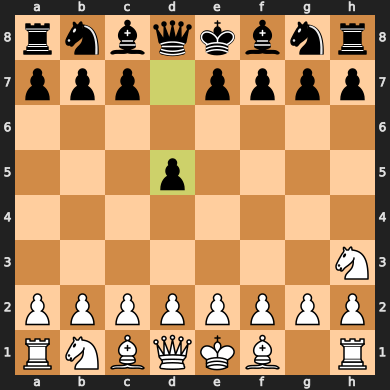

In [6]:
board

## Verify the value function

In [7]:
def calculate_diff(tensor_board, scalar=1):
    sums = torch.sum(tensor_board, dim=(1, 2))
    score = 0.025 * (sums[0]) + 0.075 * (sums[1]) + 0.0875 * (sums[2]) + 0.125 * (sums[3]) + 0.225 * (sums[4])
    return scalar * score

In [8]:
board = chess.Board()
board.push_san('e4')
board.push_san('e5')
board.push_san('g1f3')
board.push_san('b8c6')
board.push_san('f3e5')
tensor_me_after, board_tensor_black = board_to_two_tensors(board, device='cuda:0')
value_me_after, _ = model(tensor_me_after.unsqueeze(0))
print(value_me_after)
print(value_me_after + calculate_diff(tensor_me_after))

board.push_san('g7g6')
board.push_san('e5c6')
tensor_me_after, board_tensor_black = board_to_two_tensors(board, device='cuda:0')
value_me_after, _ = model(tensor_me_after.unsqueeze(0))
print(value_me_after)
print(value_me_after + calculate_diff(tensor_me_after))

board.push_san('g6g5')
# board.push_san('c6d8')
# tensor_me_after, board_tensor_black = board_to_two_tensors(board, device='cuda:0')
# value_me_after, _ = model(tensor_me_after.unsqueeze(0))
# print(value_me_after)
# print(value_me_after + calculate_diff(tensor_me_after))

# board.push_san('e8d8')
# tensor_me_after, board_tensor_black = board_to_two_tensors(board, device='cuda:0')
# value_me_after, _ = model(tensor_me_after.unsqueeze(0))
# print(value_me_after)
# print(value_me_after + calculate_diff(tensor_me_after))

# board_tensor_white, board_tensor_black = board_to_two_tensors(board)
# print(board_tensor_white.shape, board_tensor_black.shape)

tensor([[-0.5653]], device='cuda:0', grad_fn=<TanhBackward0>)
tensor([[-0.5403]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-0.5464]], device='cuda:0', grad_fn=<TanhBackward0>)
tensor([[-0.4464]], device='cuda:0', grad_fn=<AddBackward0>)


Move.from_uci('g6g5')

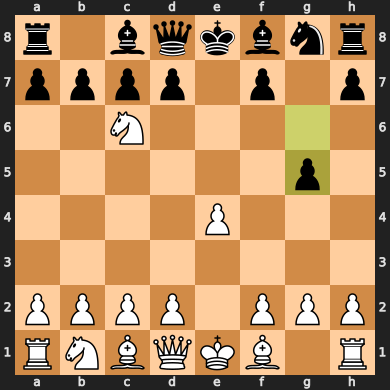

In [9]:
board

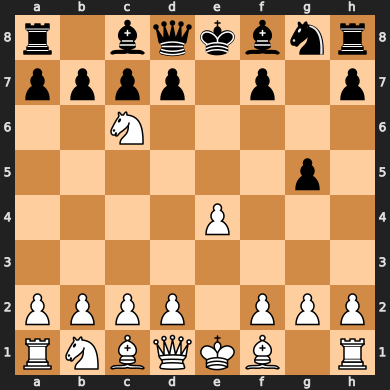

In [10]:
import chess
import chess.svg
import matplotlib.pyplot as plt
from IPython.display import display, SVG


# Disable move highlighting
svg = chess.svg.board(board, lastmove=None, squares=[])  # Remove highlights

# Display the board
display(SVG(svg))


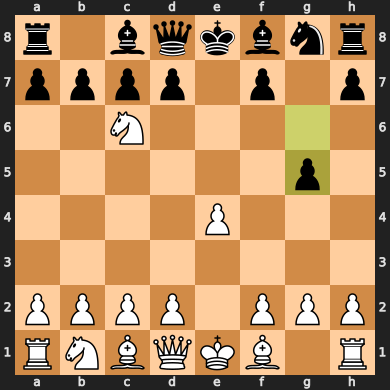

In [11]:
board

## Start the iteration

In [12]:
def epsilon_select(move_scores, epsilon):
    """Select a move using epsilon-greedy strategy."""
    if random.random() < epsilon:
        return random.choice(list(move_scores.keys()))  # Random move
    else:
        return max(move_scores.items(), key=lambda x: x[1])[0]  # Best move

def opponent_play(model, gamma=0.98, epsilon=0.3, device="cuda:0"):
    # Forward pass -- generate all the moves
    board = chess.Board()
    step_count = 0
    moves_list = []
    data_list = []      # Format: (state_t, state_{t+1}, r_t)
    
    model_turn = random.choice(['black', 'white'])
    move_order = []
    if model_turn == 'white':
        ai = AIPlayer(colour='black', from_model=from_model, to_model=to_model)
        move_order = ['model', 'ai']
        print('model white, ai black')
    else:
        ai = AIPlayer(colour='white', from_model=from_model, to_model=to_model)
        move_order = ['ai', 'model']
        print('ai white, model black')

    tensor_me_cur, _ = board_to_two_tensors(board, device)
    order_index = 0
    
    # while not board.is_game_over() and step_count < 50:  
    while not board.is_game_over():  
        turn = move_order[order_index]
        order_index = 1 - order_index
        step_count += 1  

        if turn == 'model':
            legal_moves = list(board.legal_moves)
            move_scores = {legal_move: None for legal_move in legal_moves}
            tensor_me_cur, _ = board_to_two_tensors(board, device)

            for legal_move in legal_moves:
                board.push(legal_move)

                if len(legal_moves) > 1 and board.can_claim_threefold_repetition():
                    board.pop()
                    del move_scores[legal_move]
                    continue

                if not board.turn:      # white moving
                    tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device)   
                else:       # black moving
                    tensor_oppo_after, tensor_me_after = board_to_two_tensors(board, device)   

                # Compute value for the move
                value_me_after, _ = model(tensor_me_after.unsqueeze(0))
                value_oppo_after, _ = model(tensor_oppo_after.unsqueeze(0))
                # move_scores[legal_move] = (value_me_after - value_oppo_after).item()    
                move_scores[legal_move] = (value_me_after - value_oppo_after + calculate_diff(tensor_me_after)).item()    

                board.pop()

            # move = sorted(move_scores.items(), key=lambda x: x[1], reverse=True)[0][0]
            move = epsilon_select(move_scores, epsilon)
            # print(move)
            board.push(move)
            moves_list.append(move)

            # Register the data
            if not board.turn:      # white moving
                tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device) 
            else:       # black moving
                tensor_oppo_after, tensor_me_after = board_to_two_tensors(board, device)
    
            data_list.append([tensor_me_cur, tensor_me_after, tensor_oppo_after, 0])

        else:
            move = ai.move(board=board, human_white=(model_turn=='white'))
            moves_list.append(move)

        if step_count % 50 == 0:
            print(step_count)

    # Assign rewards at the end of the game
    result = board.result()  # e.g., "1-0", "0-1", "1/2-1/2"
    
    if result == "1-0":
        final_reward = 1  # White wins
    elif result == "0-1":
        final_reward = -1  # Black wins
    else:
        final_reward = 0  # Draw

    # Apply gamma-discounted rewards
    discounted_reward = final_reward
    for i in range(len(data_list) - 1, -1, -1):  # Iterate from last to first move
        data_list[i][3] += torch.tensor([discounted_reward])
        discounted_reward *= gamma  # Decay the reward

    return data_list, result, moves_list


def self_play(model, gamma=0.98, epsilon=0.3, device="cuda:0"):
    # Forward pass -- generate all the moves
    board = chess.Board()
    step_count = 0
    moves_list = []
    data_list = []      # Format: (state_t, state_{t+1}, r_t)
    
    tensor_me_cur, _ = board_to_two_tensors(board, device)

    # while not board.is_game_over() and step_count < 50:  
    while not board.is_game_over():  
        step_count += 1  
        legal_moves = list(board.legal_moves)
        move_scores = {legal_move: None for legal_move in legal_moves}
        
        for legal_move in legal_moves:
            board.push(legal_move)

            if len(legal_moves) > 1 and board.can_claim_threefold_repetition():
                board.pop()
                del move_scores[legal_move]
                continue

            if not board.turn:      # white moving
                tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device)   
            else:       # black moving
                tensor_oppo_after, tensor_me_after = board_to_two_tensors(board, device)   

            # Compute value for the move
            value_me_after, _ = model(tensor_me_after.unsqueeze(0))
            value_oppo_after, _ = model(tensor_oppo_after.unsqueeze(0))
            # move_scores[legal_move] = (value_me_after - value_oppo_after).item()    
            move_scores[legal_move] = (value_me_after - value_oppo_after + calculate_diff(tensor_me_after)).item()    

            board.pop()

        # move = sorted(move_scores.items(), key=lambda x: x[1], reverse=True)[0][0]
        move = epsilon_select(move_scores, epsilon)
        # print(move)
        board.push(move)
        moves_list.append(move)

        # Register the data
        if not board.turn:      # white moving
            tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device) 
        else:       # black moving
            tensor_oppo_after, tensor_me_after = board_to_two_tensors(board, device)
  
        data_list.append([tensor_me_cur, tensor_me_after, tensor_oppo_after, 0])
        tensor_me_cur = tensor_oppo_after

        if step_count % 50 == 0:
            print(step_count)

    # Assign rewards at the end of the game
    result = board.result()  # e.g., "1-0", "0-1", "1/2-1/2"
    
    if result == "1-0":
        final_reward = 1  # White wins
    elif result == "0-1":
        final_reward = -1  # Black wins
    else:
        final_reward = 0  # Draw

    # Apply gamma-discounted rewards
    discounted_reward = final_reward
    for i in range(len(data_list) - 1, -1, -1):  # Iterate from last to first move
        data_list[i][3] += torch.tensor([discounted_reward])
        discounted_reward *= gamma  # Decay the reward

    return data_list, result, moves_list


    

In [13]:
data_list, result, moves_list = opponent_play(model, epsilon=.05)
print(result)

model white, ai black
1/1 [==============================] - 0s 24ms/step
0-1


In [14]:
# data_list, result, moves_list = self_play(model, epsilon=.05)
# print(result)

In [15]:
len(data_list)

20

In [16]:
data_list[0][3]

tensor([-0.6812])

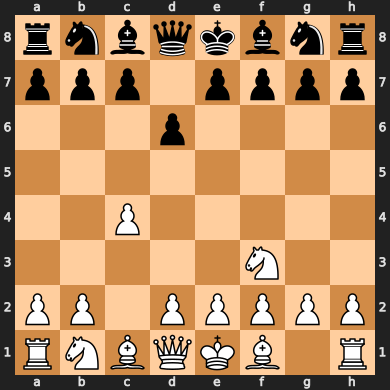

In [17]:
tensor_to_board(data_list[1][1])        # After the first move from white's perspective

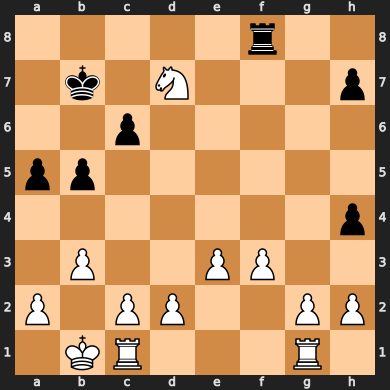

In [38]:
tensor_to_board(data_list[25][2])        # After the first move from white's perspective

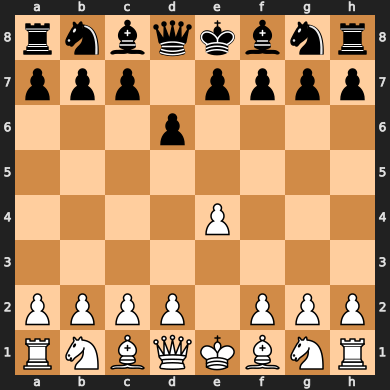

In [18]:
tensor_to_board(data_list[1][0])        # Before the second move from black's perspective

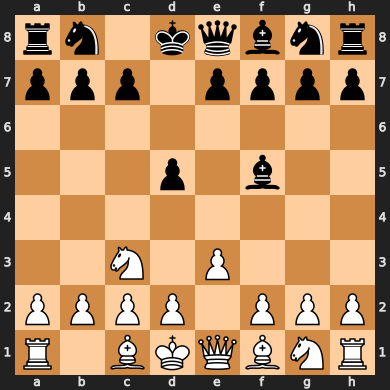

In [19]:
tensor_to_board(data_list[1][1])        # After the second move from black's perspective

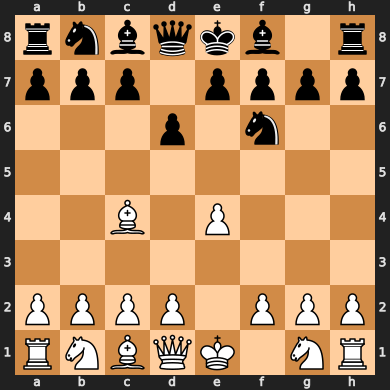

In [20]:
tensor_to_board(data_list[1][2])        # After the second move from black's perspective

In [ ]:
import time
from tqdm import tqdm

board = chess.Board()

for i in tqdm(range(len(moves_list))):
    move = moves_list[i]
    board.push(move)
    if i > 0:
        time.sleep(2)
        display(SVG(chess.svg.board(board=board, size=400)))


  0%|          | 0/13 [00:00<?, ?it/s]

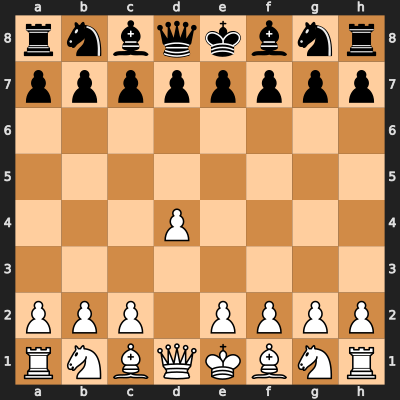

  8%|▊         | 1/13 [00:02<00:24,  2.01s/it]

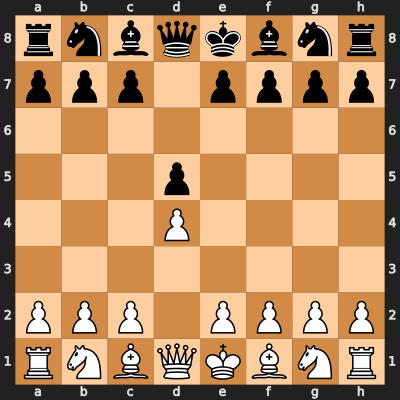

 15%|█▌        | 2/13 [00:04<00:22,  2.01s/it]

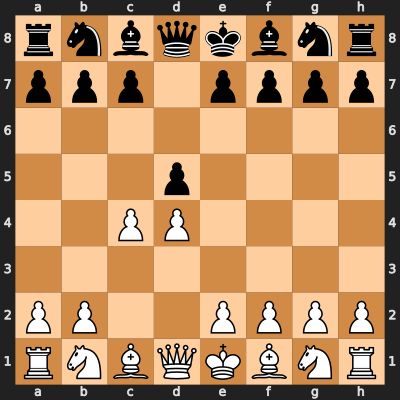

 23%|██▎       | 3/13 [00:06<00:20,  2.01s/it]

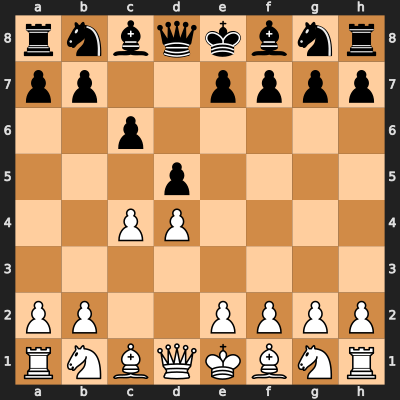

 31%|███       | 4/13 [00:08<00:18,  2.01s/it]

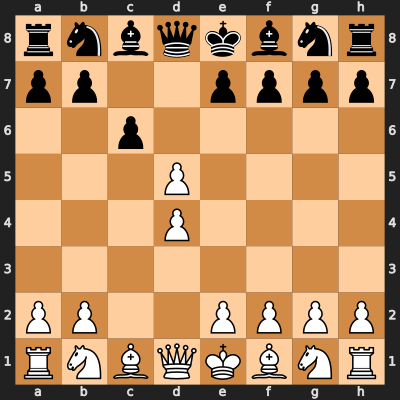

 38%|███▊      | 5/13 [00:10<00:16,  2.01s/it]

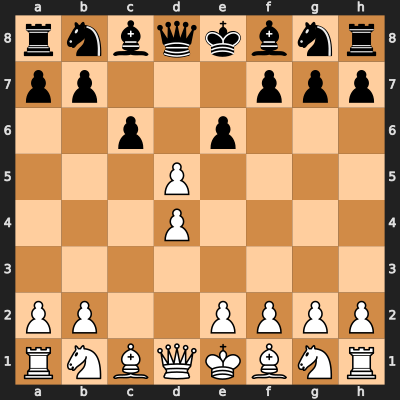

 46%|████▌     | 6/13 [00:12<00:14,  2.01s/it]

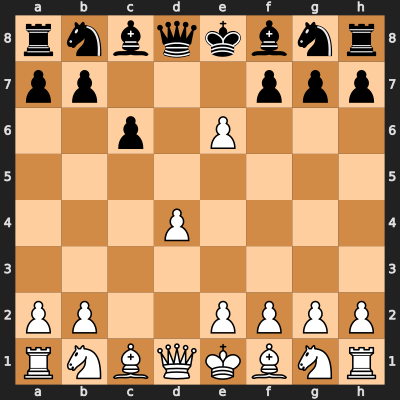

 54%|█████▍    | 7/13 [00:14<00:12,  2.07s/it]

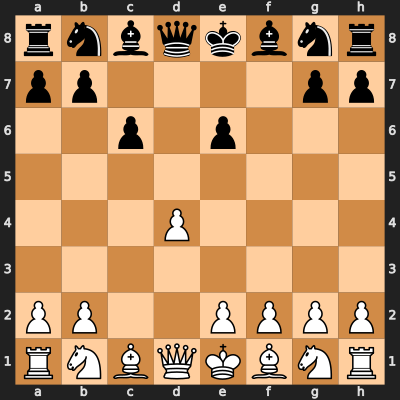

 62%|██████▏   | 8/13 [00:16<00:10,  2.05s/it]

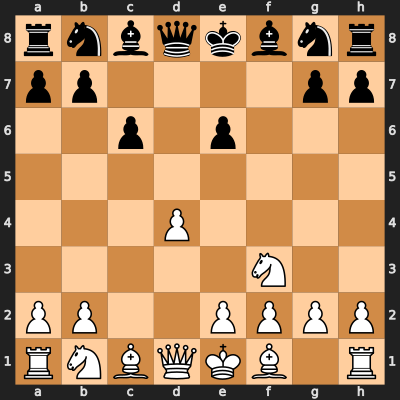

 69%|██████▉   | 9/13 [00:18<00:08,  2.04s/it]

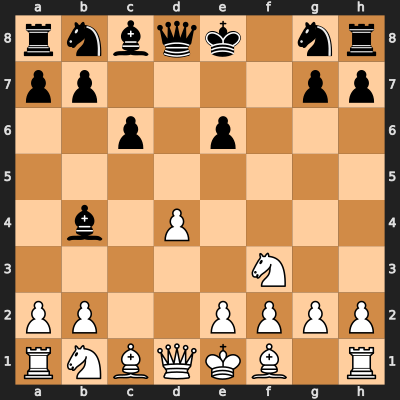

 77%|███████▋  | 10/13 [00:20<00:06,  2.03s/it]

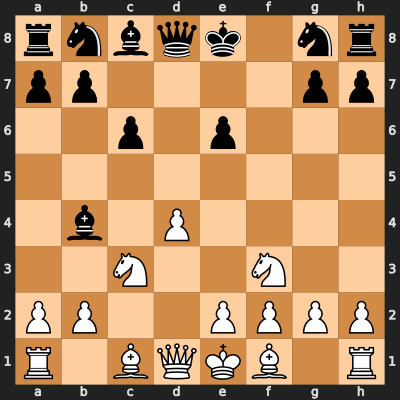

 85%|████████▍ | 11/13 [00:22<00:04,  2.02s/it]

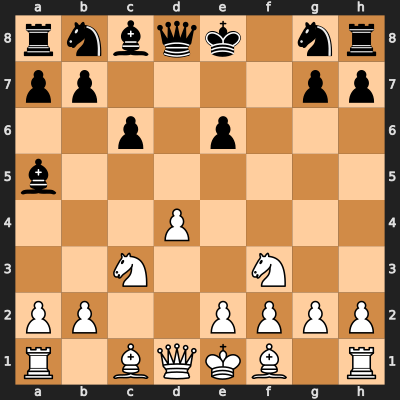

 92%|█████████▏| 12/13 [00:24<00:02,  2.02s/it]

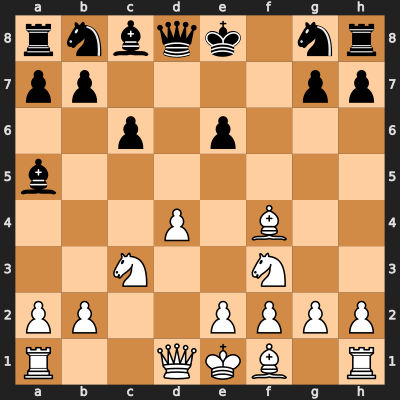

100%|██████████| 13/13 [00:26<00:00,  2.02s/it]


In [25]:
import time
import chess
import chess.svg
from tqdm import tqdm
from IPython.display import display, SVG

board = chess.Board()

moves_list = 'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'.split()

for i in tqdm(range(len(moves_list))):
    move = moves_list[i]
    try:
        board.push_san(move)  # Apply move safely
    except ValueError as e:
        print(f"Illegal move detected: {move}. Error: {e}")
        break  # Stop execution if an illegal move is encountered
    
    time.sleep(2)  # Pause before displaying
    display(SVG(chess.svg.board(board=board, size=400)))


In [21]:
moves_list

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

## TD training

In [61]:
epochs = 30
plays_per_epoch = 1
batch_size = 64
minibatch_size = 6
lr = 1e-5
device = 'cuda:0'

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr)

for epoch in range(epochs):
    # Create a replay buffer through self-playing
    buffer = []
    
    for play in tqdm(range(plays_per_epoch), desc='self-play'):
        data_list, result, moves_list = self_play(model, epsilon=.05)
        buffer += data_list

    # Sample some minibatches from the replay buffer
    pbar = tqdm(range(batch_size), desc='training')
    for batch in pbar:
        tensor_me_cur, tensor_me_after, tensor_oppo_after, reward = data_list[random.randint(0,batch_size - 1)]
        tensor_me_cur = tensor_me_cur.to(device)
        tensor_me_after = tensor_me_after.to(device)
        tensor_oppo_after = tensor_oppo_after.to(device)
        reward = reward.to(device)

        value_me_cur, _ = model(tensor_me_cur)
        value_me_after, _ = model(tensor_me_after)
        value_oppo_after, _ = model(tensor_oppo_after)

        label = reward + value_me_after - value_oppo_after
        
        loss = torch.nn.functional.mse(label, value_me_cur)
        pbar.set_postfix(loss=loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    

self-play:   0%|          | 0/1 [00:00<?, ?it/s]

50
100
150
200
250
300
350


training:   0%|          | 0/64 [00:00<?, ?it/s]


ValueError: expected 4D input (got 3D input)